## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

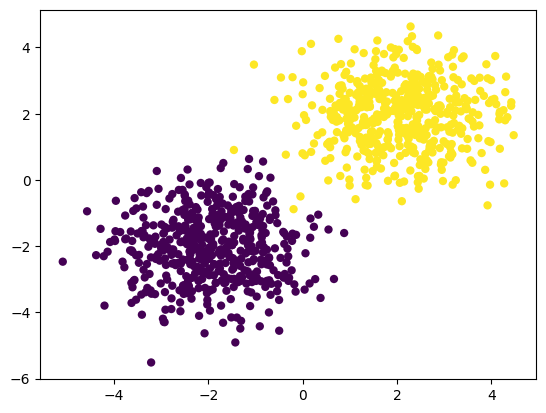

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

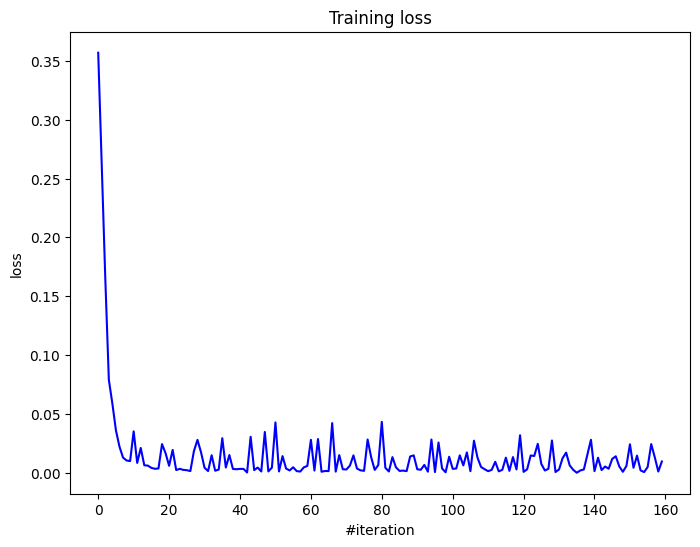

Current loss: 0.009670


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [12]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw07_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [16]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

Если 404 ошибка: то скачать напрямую файлы .gz по ссылке и добавить в рабочую директорию

1. [train-images-idx3-ubyte.gz](https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz)
2. [train-labels-idx1-ubyte.gz](https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz)
3. [t10k-images-idx3-ubyte.gz](https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz)
4. [t10k-labels-idx1-ubyte.gz](https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz)

One-hot encode the labels first.

In [20]:
net = Sequential()
net.add(Linear(784, 200))
net.add(ReLU())
net.add(BatchNormalization())
net.add(Linear(200, 10))
net.add(LogSoftMax())

In [21]:
n_classes = 10
Y_train = np.eye(n_classes)[y_train]
Y_val = np.eye(n_classes)[y_val]
Y_test = np.eye(n_classes)[y_test]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [22]:
activations = [ReLU(), ELU(), LeakyReLU(), SoftPlus()]
activation_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']

loss_histories = []

for activation, name in zip(activations, activation_names):
    print(f"Training with {name}")
    net = Sequential()
    net.add(Linear(784, 200))
    net.add(activation)
    net.add(Linear(200, 10))
    net.add(LogSoftMax())

    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate': 1e-3, 'momentum': 0.9}
    optimizer_state = {}

    loss_history = []
    n_epoch = 10
    batch_size = 128

    for epoch in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            loss_history.append(loss)
        print(f'Epoch {epoch+1}, Loss: {loss}')
    loss_histories.append((name, loss_history))

Training with ReLU
Epoch 1, Loss: 1.3128174196744198
Epoch 2, Loss: 0.6987311929013929
Epoch 3, Loss: 0.686437711409751
Epoch 4, Loss: 0.5726153786924497
Epoch 5, Loss: 0.32761202785488297
Epoch 6, Loss: 0.30388942316425194
Epoch 7, Loss: 0.48219527533779943
Epoch 8, Loss: 0.354533711472251
Epoch 9, Loss: 0.24017689451500734
Epoch 10, Loss: 0.3778124708104831
Training with ELU
Epoch 1, Loss: 1.0282289444724324
Epoch 2, Loss: 0.5412241472512351
Epoch 3, Loss: 0.5453811514653101
Epoch 4, Loss: 0.41762378806133577
Epoch 5, Loss: 0.46433792740809154
Epoch 6, Loss: 0.3172548961661505
Epoch 7, Loss: 0.5304391089836511
Epoch 8, Loss: 0.29011658672165597
Epoch 9, Loss: 0.37215003704244154
Epoch 10, Loss: 0.31951540407574036
Training with LeakyReLU
Epoch 1, Loss: 1.312667659544172
Epoch 2, Loss: 0.7598769001029658
Epoch 3, Loss: 0.5898050106410692
Epoch 4, Loss: 0.49701856812957546
Epoch 5, Loss: 0.38444730769377466
Epoch 6, Loss: 0.5185630694201199
Epoch 7, Loss: 0.24494691149584985
Epoch 8, L

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [23]:
bn_net = Sequential()
bn_net.add(Linear(784, 200))
bn_net.add(BatchNormalization())
bn_net.add(ChannelwiseScaling(200))
bn_net.add(ReLU())
bn_net.add(Linear(200, 10))
bn_net.add(LogSoftMax())

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate': 1e-3, 'momentum': 0.9}
optimizer_state = {}

bn_loss_history = []
n_epoch = 10
batch_size = 128

for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        bn_net.zeroGradParameters()
        predictions = bn_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        bn_net.backward(x_batch, dp)
        sgd_momentum(bn_net.getParameters(), bn_net.getGradParameters(), optimizer_config, optimizer_state)
        bn_loss_history.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

Epoch 1, Loss: 2.2191098274316263
Epoch 2, Loss: 1.9551188714379824
Epoch 3, Loss: 1.5186064344099255
Epoch 4, Loss: 0.9679548310779932
Epoch 5, Loss: 0.642574482514848
Epoch 6, Loss: 0.47438986868512056
Epoch 7, Loss: 0.4076342897628556
Epoch 8, Loss: 0.46316404173139836
Epoch 9, Loss: 0.47761625076324704
Epoch 10, Loss: 0.22948397357969025


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [24]:
# Momentum SGD
sgd_net = Sequential()
sgd_net.add(Linear(784, 200))
sgd_net.add(ReLU())
sgd_net.add(Linear(200, 10))
sgd_net.add(LogSoftMax())

criterion = ClassNLLCriterion()
optimizer_config_sgd = {'learning_rate': 1e-3, 'momentum': 0.9}
optimizer_state_sgd = {}

sgd_loss_history = []
n_epoch = 10
batch_size = 128

for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        sgd_net.zeroGradParameters()
        predictions = sgd_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        sgd_net.backward(x_batch, dp)
        sgd_momentum(sgd_net.getParameters(), sgd_net.getGradParameters(), optimizer_config_sgd, optimizer_state_sgd)
        sgd_loss_history.append(loss)
    print(f'SGD Epoch {epoch+1}, Loss: {loss}')

# Adam
adam_net = Sequential()
adam_net.add(Linear(784, 200))
adam_net.add(ReLU())
adam_net.add(Linear(200, 10))
adam_net.add(LogSoftMax())

optimizer_config_adam = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state_adam = {}

adam_loss_history = []
n_epoch = 10
batch_size = 128

for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        adam_net.zeroGradParameters()
        predictions = adam_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        adam_net.backward(x_batch, dp)
        adam_optimizer(adam_net.getParameters(), adam_net.getGradParameters(), optimizer_config_adam, optimizer_state_adam)
        adam_loss_history.append(loss)
    print(f'Adam Epoch {epoch+1}, Loss: {loss}')

SGD Epoch 1, Loss: 1.302463753365342
SGD Epoch 2, Loss: 0.7386547981367316
SGD Epoch 3, Loss: 0.5012027532486611
SGD Epoch 4, Loss: 0.47344606869048944
SGD Epoch 5, Loss: 0.3487903681220651
SGD Epoch 6, Loss: 0.3691538873379498
SGD Epoch 7, Loss: 0.44346600146871606
SGD Epoch 8, Loss: 0.28157428359042136
SGD Epoch 9, Loss: 0.4288042757215316
SGD Epoch 10, Loss: 0.40212060348497525
Adam Epoch 1, Loss: 0.1687841731370396
Adam Epoch 2, Loss: 0.11649318455044524
Adam Epoch 3, Loss: 0.13936790319155481
Adam Epoch 4, Loss: 0.0735735479696951
Adam Epoch 5, Loss: 0.06193725575253489
Adam Epoch 6, Loss: 0.02760219826315328
Adam Epoch 7, Loss: 0.0778429706271938
Adam Epoch 8, Loss: 0.05575499286068238
Adam Epoch 9, Loss: 0.022101460101500162
Adam Epoch 10, Loss: 0.011687282997348182


Print here your accuracy on test set. It should be around 90%.

In [26]:
final_net = Sequential()
final_net.add(Dropout(0.2))
final_net.add(Linear(784, 512))
final_net.add(BatchNormalization())
final_net.add(ChannelwiseScaling(512))
final_net.add(ReLU())
final_net.add(Dropout(0.5))
final_net.add(Linear(512, 256))
final_net.add(BatchNormalization())
final_net.add(ChannelwiseScaling(256))
final_net.add(ReLU())
final_net.add(Dropout(0.5))
final_net.add(Linear(256, 10))
final_net.add(LogSoftMax())

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

n_epoch = 10
batch_size = 128
scheduler = lambda lr, epoch: lr * 0.95**epoch

loss_history = []

for epoch in range(n_epoch):
    optimizer_config['learning_rate'] = scheduler(1e-3, epoch)
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        final_net.train()
        final_net.zeroGradParameters()
        predictions = final_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        final_net.backward(x_batch, dp)
        adam_optimizer(final_net.getParameters(), final_net.getGradParameters(), optimizer_config, optimizer_state)
        loss_history.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

# Evaluate on test set
final_net.evaluate()
test_preds = final_net.forward(X_test)
test_accuracy = np.mean(np.argmax(test_preds, axis=1) == y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1, Loss: 0.33632087732276716
Epoch 2, Loss: 0.10031521749007832
Epoch 3, Loss: 0.2562221498282623
Epoch 4, Loss: 0.16765953818333396
Epoch 5, Loss: 0.21760635876252804
Epoch 6, Loss: 0.30196160794489413
Epoch 7, Loss: 0.10995369796640338
Epoch 8, Loss: 0.055827772167762545
Epoch 9, Loss: 0.018489777840631383
Epoch 10, Loss: 0.08831852850456591
Test Accuracy: 97.90%


### Comparing with PyTorch implementation
The last (and maybe the easiest) step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

__Good Luck!__

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x

model = PyTorchModel()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

n_epoch = 10
for epoch in range(n_epoch):
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == Y_test_tensor.argmax(dim=1)).float().mean()
    print(f'PyTorch Test Accuracy: {accuracy.item() * 100:.2f}%')

Epoch 1, Loss: 0.188844233751297
Epoch 2, Loss: 0.21791747212409973
Epoch 3, Loss: 0.16707220673561096
Epoch 4, Loss: 0.1519009917974472
Epoch 5, Loss: 0.21871551871299744
Epoch 6, Loss: 0.1803991198539734
Epoch 7, Loss: 0.08821949362754822
Epoch 8, Loss: 0.1998624950647354
Epoch 9, Loss: 0.11164204031229019
Epoch 10, Loss: 0.2673441171646118
PyTorch Test Accuracy: 98.07%
